In [1]:
# coding: utf-8
# Used for getting hdf5 training data from a folder of images
# Reference: https://github.com/google/inception/blob/master/inception.ipynb
# Modified by Yantian Zha at Yochan lab, ASU, on April 2016

from IPython import display
from matplotlib import pyplot
import numpy as np
import os
import os.path  # Yantian
import sys
%matplotlib inline

# Make sure that you set this to the location your caffe2 library lies.
caffe2_root = '/home/yochan/DL/caffe2/'
sys.path.insert(0, os.path.join(caffe2_root, 'gen'))

# After setting the caffe2 root path, we will import all the caffe2 libraries needed.
from caffe2.proto import caffe2_pb2
#from pycaffe2 import core, net_drawer, workspace, visualize
from caffe2.python import core, net_drawer, workspace, visualize

Mint is not available, possibly due to some downstream dependencies. Error is: No module named flask.


In [2]:
# net is the network definition.
net = caffe2_pb2.NetDef()
net.ParseFromString(open('inception_net.pb').read())
# tensors contain the parameter tensors.
tensors = caffe2_pb2.TensorProtos()
tensors.ParseFromString(open('inception_tensors.pb').read())
# Yantian, illustrated by multibox.py
for op in net.op:
    if op.type == 'MaxPool':
        del op.output[1:]

Visualizing network: inception


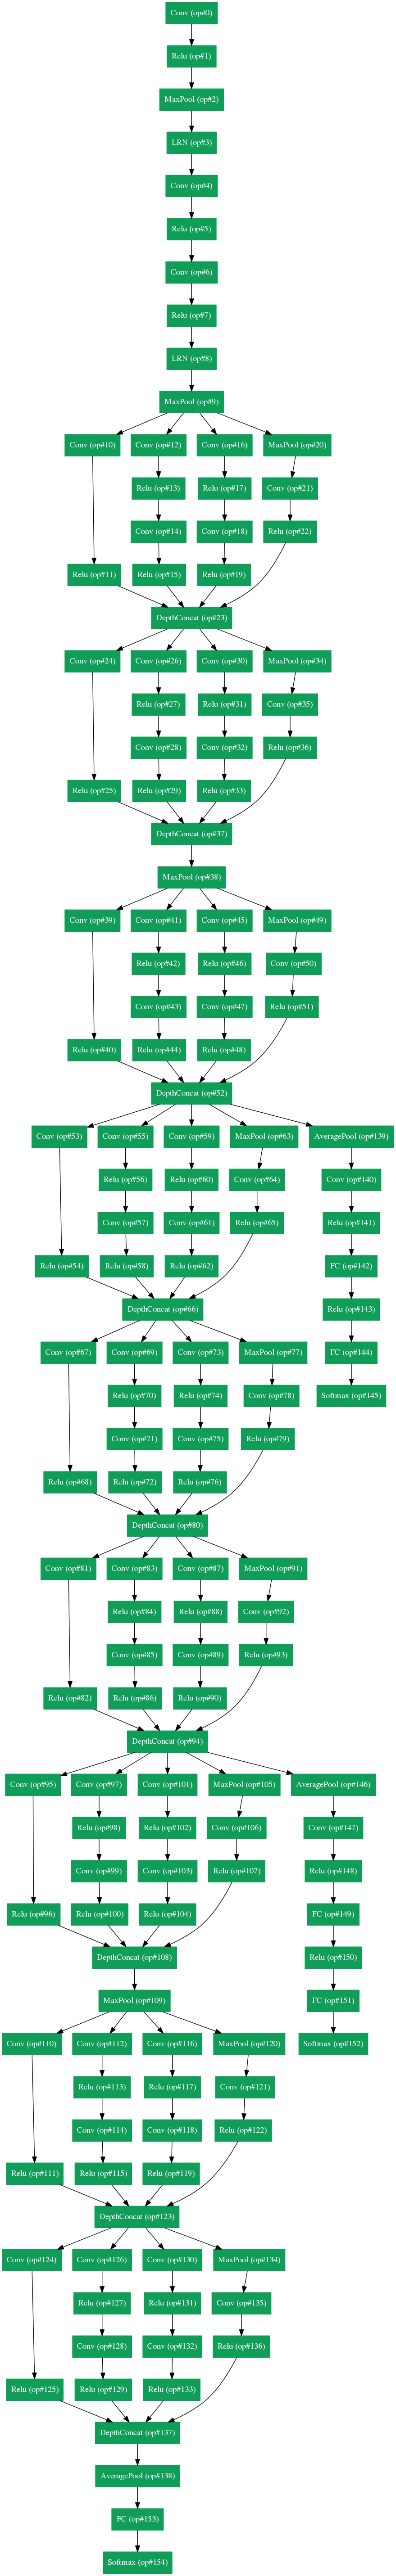

In [3]:
# Note that the following line hides the intermediate blobs and only shows the operators.
# If you want to show all the blobs as well, use the commented GetPydotGraph line.
graph = net_drawer.GetPydotGraphMinimal(net.op, name="inception", rankdir='TB')
#graph = net_drawer.GetPydotGraph(net.op, name="inception", rankdir='TB')

print 'Visualizing network:', net.name
display.Image(graph.create_png(), width=200)

In [4]:
DEVICE_OPTION = caffe2_pb2.DeviceOption()
# Let's use CPU in our example.
DEVICE_OPTION.device_type = caffe2_pb2.CPU

# If you have a GPU and want to run things there, uncomment the below two lines.
# If you have multiple GPUs, you also might want to specify a gpu id.
#DEVICE_OPTION.device_type = caffe2_pb2.CUDA
#DEVICE_OPTION.cuda_gpu_id = 0

# Caffe2 has a concept of "workspace", which is similar to that of Matlab. Each workspace
# is a self-contained set of tensors and networks. In this case, we will just use the default
# workspace so we won't dive too deep into it.
workspace.SwitchWorkspace('default')

# First, we feed all the parameters to the workspace.
for param in tensors.protos:
    workspace.FeedBlob(param.name, param, DEVICE_OPTION)
# The network expects an input blob called "input", which we create here.
# The content of the input blob is going to be fed when we actually do
# classification.
workspace.CreateBlob("input")
# Specify the device option of the network, and then create it.
net.device_option.CopyFrom(DEVICE_OPTION)
workspace.CreateNet(net)

True

In [5]:
def ClassifyImageWithInception(image_file, show_image=True, output_name="softmax2"):
    from skimage import io, transform
    img = io.imread(image_file)

    # Crop the center
    shorter_edge = min(img.shape[:2])
    crop_height = (img.shape[0] - shorter_edge) / 2
    crop_width = (img.shape[1] - shorter_edge) / 2
    cropped_img = img[crop_height:crop_height + shorter_edge, crop_width:crop_width + shorter_edge]
    # Resize the image to 224 * 224
    resized_img = transform.resize(cropped_img, (224, 224))
    if show_image:
        pyplot.imshow(resized_img)
    # normalize the image and feed it into the network. The network expects
    # a four-dimensional tensor, since it can process images in batches. In our
    # case, we will basically make the image as a batch of size one.
    normalized_img = resized_img.reshape((1, 224, 224, 3)).astype(np.float32) * 256 - 117
    workspace.FeedBlob("input", normalized_img, DEVICE_OPTION)
    workspace.RunNet("inception")
    return workspace.FetchBlob(output_name)

Processing file:
12
First layer output shape: (1, 7, 7, 1024)
<type 'numpy.ndarray'>
Processing file:
2
First layer output shape: (1, 7, 7, 1024)
<type 'numpy.ndarray'>
Processing file:
9
First layer output shape: (1, 7, 7, 1024)
<type 'numpy.ndarray'>
Processing file:
3
First layer output shape: (1, 7, 7, 1024)
<type 'numpy.ndarray'>
Processing file:
10
First layer output shape: (1, 7, 7, 1024)
<type 'numpy.ndarray'>
Processing file:
4
First layer output shape: (1, 7, 7, 1024)
<type 'numpy.ndarray'>
Processing file:
7
First layer output shape: (1, 7, 7, 1024)
<type 'numpy.ndarray'>
Processing file:
5
First layer output shape: (1, 7, 7, 1024)
<type 'numpy.ndarray'>
Processing file:
11
First layer output shape: (1, 7, 7, 1024)
<type 'numpy.ndarray'>
Processing file:
8
First layer output shape: (1, 7, 7, 1024)
<type 'numpy.ndarray'>
Processing file:
6
First layer output shape: (1, 7, 7, 1024)
<type 'numpy.ndarray'>
Processing file:
1
First layer output shape: (1, 7, 7, 1024)
<type 'numpy

RuntimeError: unable to create link (Links: Unable to initialize object)

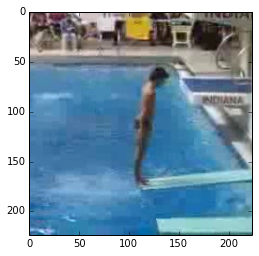

In [6]:
video_dir = '/home/yochan/DL/action-recognition-visual-attention-master/dataset/genFrames'
#dataset = []
dataset = {}
for dirpath, dirnames, filenames in os.walk(video_dir):
    for filename in [f for f in filenames if f.endswith(".jpg")]:
        #print "Processing file:\n", filename
        s_fname = os.path.splitext(filename)[0]
        print "Processing file:\n", s_fname
        predictions = ClassifyImageWithInception(os.path.join(dirpath, filename)).flatten()
        #idx = np.argmax(predictions)
        #print 'Prediction: %d, synset %s' % (idx, synsets[idx])
        mixed5b = workspace.FetchBlob('mixed5b')
        print 'First layer output shape:', mixed5b.shape
        #dataset.append((int(s_fname), mixed5b))
        dataset[int(s_fname)] = mixed5b
        print type(mixed5b)

#dataset = sorted(dataset)  # sorted with 1st item
import collections
dataset = collections.OrderedDict(sorted(dataset.items()))

import h5py

f = h5py.File('771024.h5', 'w')
#dset = f.create_dataset("features", (len(dataset.keys()), 7*7*1024), maxshape=(None, None))
for ky, val in dataset.iteritems():
#    print val
#    dset[ky,...] = val
    f['ky'] = val
f.close()

# create csv
#import csv
#writer = csv.writer(open('./features.csv', 'w+'))
#for key, value in dataset.items():
#    writer.writerow([key, value])

# create dataset for matlab
# import scipy.io as sio
# datamat = {}
# datamat['dataset'] = dataset
# sio.savemat('./test_dataset.mat', datamat)
        
